we will drastically undersample banks 11 and 12 (which are likely overrepresented), we’ll rewrite the data filtering section to:

Keep all other banks’ data as-is.

Randomly sample a small fraction of bank 11 and bank 12 transactions (e.g., 5% each).

Concatenate them back together to form your undersampled dataset.

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('../fl/data/HI-Medium_Trans.csv', low_memory=False)

# Remove formats with no suspicious activity
df = df[~df['Payment Format'].isin(['Reinvestment', 'Wire'])]

# Feature engineering
df['currency_change'] = np.where(df['Receiving Currency'] != df['Payment Currency'], 1, 0)
df['self_to_self'] = np.where(df['Account'] == df['Account.1'], 1, 0)

# Rename columns
df.rename(columns={
    "Timestamp": "timestamp",
    "From Bank": "from_bank",
    "Account": "from_account",
    "To Bank": "to_bank",
    "Account.1": "to_account",
    "Amount Received": "amount_received",
    "Receiving Currency": "receiving_currency",
    "Amount Paid": "amount_paid",
    "Payment Currency": "payment_currency",
    "Payment Format": "payment_format",
    "Is Laundering": "is_laundering"
}, inplace=True)

banks_to_downsample = [11, 12] # Undersample banks 11 and 12 transactions
downsample_fraction = 1.0

# Identify bank 11 and 12 rows by from_bank or to_bank
df_banks_11_12 = df[(df['from_bank'].isin(banks_to_downsample)) | (df['to_bank'].isin(banks_to_downsample))]
df_banks_11_12_sampled = df_banks_11_12.sample(frac=downsample_fraction, random_state=42)

# Keep all other banks' data as-is
# df_other_banks = df[~((df['from_bank'].isin(banks_to_downsample)) | (df['to_bank'].isin(banks_to_downsample)))]

# Combine undersampled + other banks
# df = pd.concat([df_other_banks, df_banks_11_12_sampled], axis=0).reset_index(drop=True)

# Timestamp features
df_banks_11_12_sampled['timestamp'] = pd.to_datetime(df_banks_11_12_sampled['timestamp'], errors='coerce')
df_banks_11_12_sampled['tx_hour'] = df_banks_11_12_sampled['timestamp'].dt.hour
df_banks_11_12_sampled['tx_day'] = df_banks_11_12_sampled['timestamp'].dt.dayofweek
df_banks_11_12_sampled['tx_month'] = df_banks_11_12_sampled['timestamp'].dt.month

# Label encode categorical features
for col in ['payment_format', 'receiving_currency', 'payment_currency']:
    df_banks_11_12_sampled[col] = LabelEncoder().fit_transform(df_banks_11_12_sampled[col].astype(str))

# Final feature set
features = [
    'amount_received', 'amount_paid', 'tx_hour', 'tx_day', 'tx_month',
    'payment_format', 'currency_change', 'self_to_self',
    'receiving_currency', 'payment_currency'
]
target = 'is_laundering'

# Drop NA and create modeling dataset
df_model = df_banks_11_12_sampled[features + [target]].dropna()

print("Final shape of undersampled dataset:", df_model.shape)
print(df_model['is_laundering'].value_counts())


Final shape of undersampled dataset: (422552, 11)
0    421651
1       901
Name: is_laundering, dtype: int64


In [20]:
len(features)

10

Prepare tensors with gaussian noise

In [28]:
from sklearn.preprocessing import StandardScaler
import torch

torch.manual_seed(42) # Added random seed - Arron

X = StandardScaler().fit_transform(df_model[features])
y = df_model[target].astype(np.float32).values.reshape(-1, 1)

# Add small Gaussian noise to features
noise = np.random.normal(0, 0.01, X.shape)
X += noise

# Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [29]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1024)
test_dl = DataLoader(test_ds, batch_size=1024)


Simple regularized model

In [30]:
import torch.nn as nn

class AMLNet(nn.Module): # Small model - Arron
    def __init__(self, input_dim): 
        super(AMLNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1)  # No sigmoid here
        )

    def forward(self, x):
        return self.model(x)


model = AMLNet(X.shape[1])


Training loop and early stopping rounds

before scaling down poswt:  467.9811320754717
Epoch 1 - Train Loss: 1.3953, Val Loss: 1.2657
Epoch 2 - Train Loss: 1.0149, Val Loss: 1.1082
Epoch 3 - Train Loss: 0.9325, Val Loss: 1.0152
Epoch 4 - Train Loss: 0.8711, Val Loss: 0.9504
Epoch 5 - Train Loss: 0.7999, Val Loss: 0.8933
Epoch 6 - Train Loss: 0.7500, Val Loss: 0.8528
Epoch 7 - Train Loss: 0.7167, Val Loss: 0.8118
Epoch 8 - Train Loss: 0.6833, Val Loss: 0.7787
Epoch 9 - Train Loss: 0.6359, Val Loss: 0.7564
Epoch 10 - Train Loss: 0.6315, Val Loss: 0.7267
Epoch 11 - Train Loss: 0.6181, Val Loss: 0.7097
Epoch 12 - Train Loss: 0.5863, Val Loss: 0.7008
Epoch 13 - Train Loss: 0.5807, Val Loss: 0.6873
Epoch 14 - Train Loss: 0.5753, Val Loss: 0.6734
Epoch 15 - Train Loss: 0.5479, Val Loss: 0.6822
Epoch 16 - Train Loss: 0.5418, Val Loss: 0.6691
Epoch 17 - Train Loss: 0.5400, Val Loss: 0.6646
Epoch 18 - Train Loss: 0.5265, Val Loss: 0.6615
Epoch 19 - Train Loss: 0.5262, Val Loss: 0.6612
Epoch 20 - Train Loss: 0.5413, Val Loss: 0.6471
Epo

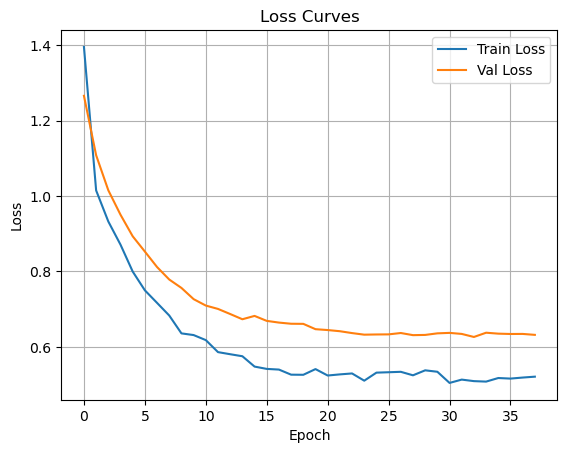

Threshold 0.10 → F1 Score: 0.0218
Threshold 0.15 → F1 Score: 0.0247
Threshold 0.20 → F1 Score: 0.0286
Threshold 0.25 → F1 Score: 0.0331
Threshold 0.30 → F1 Score: 0.0340
Threshold 0.35 → F1 Score: 0.0345
Threshold 0.40 → F1 Score: 0.0354
Threshold 0.45 → F1 Score: 0.0359
Threshold 0.50 → F1 Score: 0.0359
Threshold 0.55 → F1 Score: 0.0359
Threshold 0.60 → F1 Score: 0.0359
Threshold 0.65 → F1 Score: 0.0361
Threshold 0.70 → F1 Score: 0.0360
Threshold 0.75 → F1 Score: 0.0363
Threshold 0.80 → F1 Score: 0.0387
Threshold 0.85 → F1 Score: 0.0487

Best Threshold: 0.85 with F1: 0.0487

Test Metrics
              precision    recall  f1-score   support

         0.0     0.9995    0.9355    0.9664     84318
         1.0     0.0268    0.7772    0.0519       193

    accuracy                         0.9351     84511
   macro avg     0.5131    0.8564    0.5092     84511
weighted avg     0.9972    0.9351    0.9643     84511

ROC AUC: 0.9486470660601789


In [36]:
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Calculate positive class weight
positive_weight = (df_model['is_laundering'] == 0).sum() / (df_model['is_laundering'] == 1).sum()
print('before scaling down poswt: ', positive_weight)
# positive_weight = min(positive_weight, 10.0) 
# print('after scaling down poswt: ', positive_weight)

pos_weight_tensor = torch.tensor([positive_weight], dtype=torch.float32)

# Use BCEWithLogitsLoss for class weighting
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

# def train(model, train_dl, val_dl, epochs=50, patience=5, model_save_path="../fl/checkpoints/best_model_limited_baseline.pkl"):
def train(model, train_dl, val_dl, df_model, epochs=50, patience=5, model_save_path="../fl/checkpoints/best_model_limited_baseline.pkl"):
    best_val_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        train_loss = total_loss / len(train_dl.dataset)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * xb.size(0)

        val_loss = val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    # model.load_state_dict(best_model)
    # Save best model to file
    if best_model is not None:
        torch.save(best_model, model_save_path)
        model.load_state_dict(best_model)
        print(f"Best model saved to: {model_save_path}")


    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

    return model

def tune_threshold(model, val_dl):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_thresh = 0.5
    best_f1 = 0

    y_true_all, y_prob_all = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in val_dl:
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_all.extend(yb.cpu().numpy())
            y_prob_all.extend(probs)

    y_true = np.array(y_true_all)
    y_prob = np.array(y_prob_all)

    for thresh in thresholds:
        preds = (y_prob > thresh).astype(int)
        f1 = f1_score(y_true, preds)
        print(f"Threshold {thresh:.2f} → F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"\nBest Threshold: {best_thresh:.2f} with F1: {best_f1:.4f}")
    return best_thresh


def evaluate(model, test_dl, threshold=0.5):
    y_true, y_prob = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in test_dl:
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true.extend(yb.cpu().numpy())
            y_prob.extend(probs)

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob > threshold).astype(int)

    print("\nTest Metrics")
    print(classification_report(y_true, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))


# train(model, train_dl, val_dl, epochs=50, patience=5)
model = train(model, train_dl, val_dl, df_model, epochs=50, patience=5) # Train model

best_threshold = tune_threshold(model, val_dl) # Tune threshold using validation set

evaluate(model, test_dl, threshold=best_threshold) # Evaluate on test set



In [46]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix

model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_probs.extend(probs.view(-1).tolist())
        y_true.extend(yb.view(-1).tolist())

# Binary predictions
y_pred = [1 if p > 0.85 else 0 for p in y_probs]

# Updated the performance metrics - Arron

# Confusion matrix to calculate FPR
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # False Positive Rate

# Evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

# Print metrics
print("Accuracy :", accuracy)
print("FPR      :", fpr)
print("Precision:", precision)
print("Recall   :", recall)
print("ROC AUC  :", roc_auc)


Accuracy : 0.9351445373974986
FPR      : 0.06449393960957328
Precision: 0.026843235504652826
Recall   : 0.7772020725388601
ROC AUC  : 0.9486470660601789


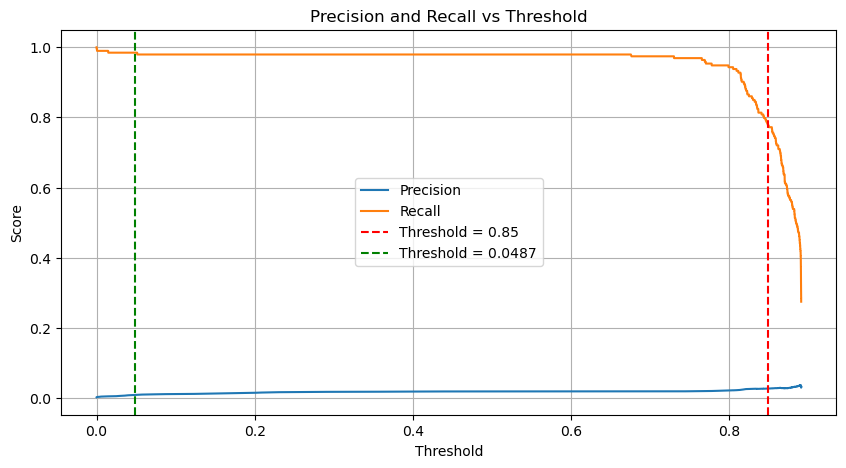

In [40]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=0.85, color='red', linestyle='--', label='Threshold = 0.85')
plt.axvline(x=0.0487, color='green', linestyle='--', label='Threshold = 0.0487')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


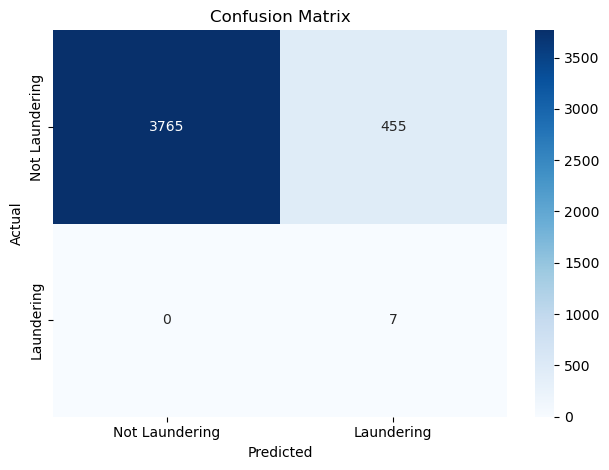

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Laundering", "Laundering"], yticklabels=["Not Laundering", "Laundering"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# 6,379,649 --> total transactions
# 5,586,578 --> true negatives
# 785,979 --> false positive --> 12.32009% 
# 6210 -> true positive  --> 0.09% 
# 882 --> false negative

In [9]:
# torch.save(best_model, "model_weights/best_aml_model_regularized.pth")

# model.load_state_dict(torch.load("best_aml_model.pth"))
# model.eval()


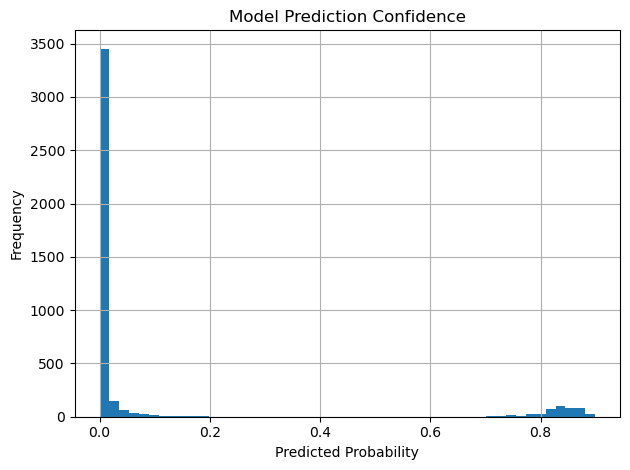

In [10]:
plt.hist(y_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Model Prediction Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()


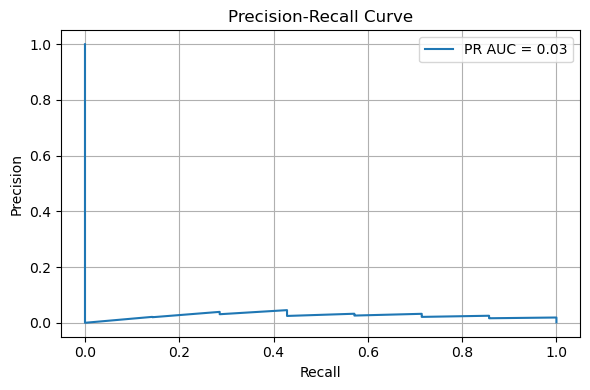

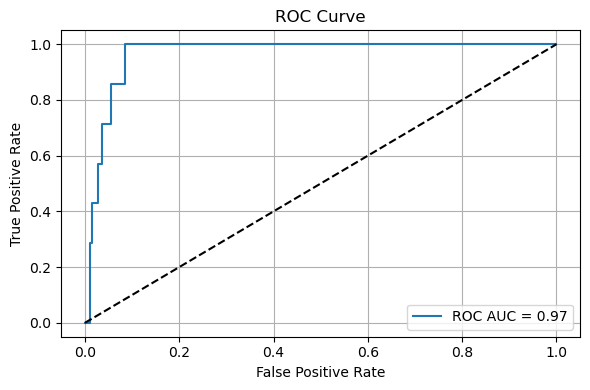

In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
import pickle
from aml_model import AMLNet

In [26]:
# Define your model architecture
model = AMLNet(10)  # Replace with your actual model class

# Load the weights
with open('../best_model.pkl', 'rb') as file:
    model = torch.load(file, weights_only=False)

In [27]:
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_probs.extend(probs.view(-1).tolist())
        y_true.extend(yb.view(-1).tolist())

# Binary predictions
y_pred = [1 if p > 0.5 else 0 for p in y_probs]

# Updated the performance metrics - Arron

# Confusion matrix to calculate FPR
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # False Positive Rate

# Evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

# Print metrics
print("Accuracy :", accuracy)
print("FPR      :", fpr)
print("Recall   :", recall)
print("ROC AUC  :", roc_auc)

Accuracy : 0.8779269729093051
FPR      : 0.12228703681836431
Recall   : 0.9626168224299065
ROC AUC  : 0.9291809369013757


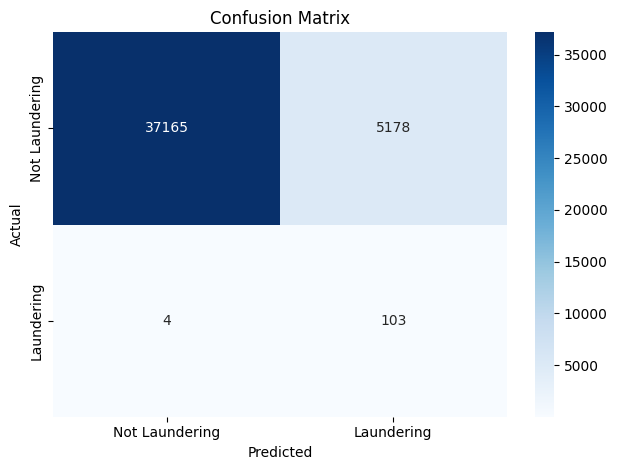

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Laundering", "Laundering"], yticklabels=["Not Laundering", "Laundering"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()